In [24]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

In [25]:
df = pd.read_csv('/Users/bhadrinathboddu/Documents/Guvi/Toxic Tweets Classification/FinalBalancedDataset.csv')

In [26]:
df.head()

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


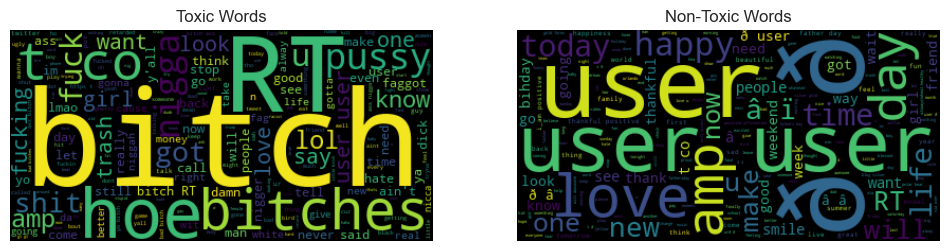

In [27]:
toxic_words = ' '.join(df[df['Toxicity'] == 1]['tweet'])
non_toxic_words = ' '.join(df[df['Toxicity'] == 0]['tweet'])

toxic_wordcloud = WordCloud().generate(toxic_words)
non_toxic_wordcloud = WordCloud().generate(non_toxic_words)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.title('Toxic Words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('Non-Toxic Words')
plt.axis('off')

plt.show()

In [28]:
df.drop('Unnamed: 0',axis=1)

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
56741,1,"you've gone and broke the wrong heart baby, an..."
56742,1,young buck wanna eat!!.. dat nigguh like I ain...
56743,1,youu got wild bitches tellin you lies


In [29]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to form cleaned text
    cleaned_text = ' '.join(tokens)
    return cleaned_text


df['cleaned_tweet'] = df['tweet'].apply(clean_text)


In [30]:
df['cleaned_tweet']

0        user father dysfunctional selfish drag kid dys...
1        user user thanks lyft credit cant use cause do...
2                                           bihday majesty
3                              model love u take u time ur
4                            factsguide society motivation
                               ...                        
56740    yous muthafin lie lifeasking pearl coreyemanue...
56741    youve gone broke wrong heart baby drove rednec...
56742    young buck wan na eat dat nigguh like aint fuc...
56743                       youu got wild bitch tellin lie
56744    ruffled ntac eileen dahlia beautiful color com...
Name: cleaned_tweet, Length: 56745, dtype: object

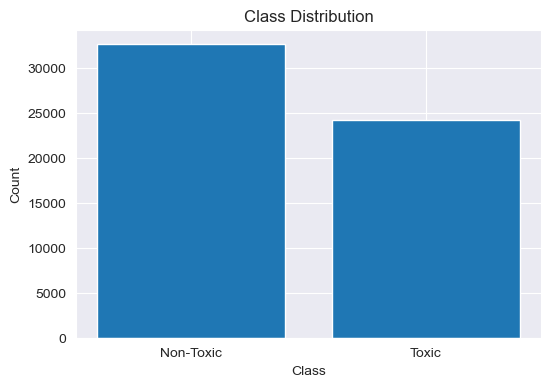

In [31]:
class_distribution = df['Toxicity'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(class_distribution.index, class_distribution.values)
plt.xticks(class_distribution.index, ['Non-Toxic', 'Toxic'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [32]:
# Data splitting
subset_size = 25000
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_tweet'][:subset_size], df['Toxicity'][:subset_size], test_size=0.2, random_state=42)

In [33]:

# Bag of Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [34]:

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [35]:

# Define the models
models = {
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB(),
    'K-NN Classifier': KNeighborsClassifier(),
    'SVM': SVC(probability=True)
}

In [36]:

# Function to calculate metrics
def generate_metrics(y_true, y_pred_probs, model_name):
    y_pred = (y_pred_probs >= 0.5).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    print(f"{model_name} Metrics:\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")
    return precision, recall, f1, roc_auc

In [37]:
# Train and predict for Bag of Words and TF-IDF
metrics_list = []
for model_name, model in models.items():
    # Bag of Words
    model.fit(X_train_bow, y_train)
    predictions_bow = model.predict_proba(X_test_bow)[:, 1]
    precision_bow, recall_bow, f1_bow, roc_auc_bow = generate_metrics(y_test, predictions_bow, model_name + ' (Bag of Words)')
    metrics_list.append((model_name + ' (Bag of Words)', precision_bow, recall_bow, f1_bow, roc_auc_bow))

    # TF-IDF
    model.fit(X_train_tfidf, y_train)
    predictions_tfidf = model.predict_proba(X_test_tfidf)[:, 1]
    precision_tfidf, recall_tfidf, f1_tfidf, roc_auc_tfidf = generate_metrics(y_test, predictions_tfidf, model_name + ' (TF-IDF)')
    metrics_list.append((model_name + ' (TF-IDF)', precision_tfidf, recall_tfidf, f1_tfidf, roc_auc_tfidf))

Decision Trees (Bag of Words) Metrics:
Precision: 0.60, Recall: 0.57, F1-score: 0.58, ROC-AUC: 0.78
Decision Trees (TF-IDF) Metrics:
Precision: 0.57, Recall: 0.57, F1-score: 0.57, ROC-AUC: 0.77
Random Forest (Bag of Words) Metrics:
Precision: 0.88, Recall: 0.51, F1-score: 0.64, ROC-AUC: 0.94
Random Forest (TF-IDF) Metrics:
Precision: 0.89, Recall: 0.48, F1-score: 0.63, ROC-AUC: 0.94
Naive Bayes (Bag of Words) Metrics:
Precision: 0.83, Recall: 0.47, F1-score: 0.60, ROC-AUC: 0.93
Naive Bayes (TF-IDF) Metrics:
Precision: 1.00, Recall: 0.14, F1-score: 0.24, ROC-AUC: 0.91
K-NN Classifier (Bag of Words) Metrics:
Precision: 0.95, Recall: 0.17, F1-score: 0.28, ROC-AUC: 0.73
K-NN Classifier (TF-IDF) Metrics:
Precision: 0.98, Recall: 0.17, F1-score: 0.29, ROC-AUC: 0.67
SVM (Bag of Words) Metrics:
Precision: 0.75, Recall: 0.57, F1-score: 0.65, ROC-AUC: 0.95
SVM (TF-IDF) Metrics:
Precision: 0.74, Recall: 0.62, F1-score: 0.67, ROC-AUC: 0.96


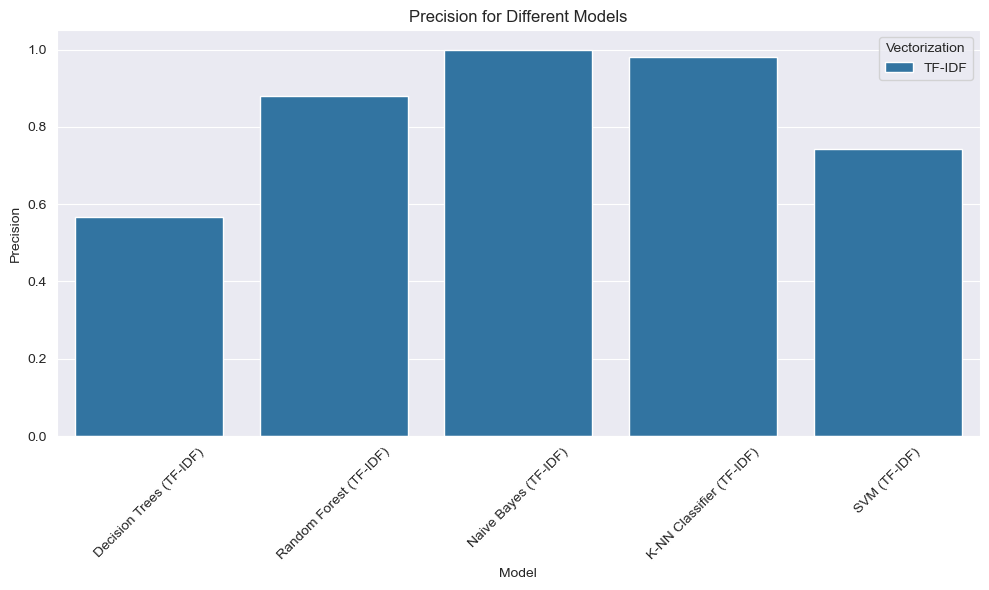

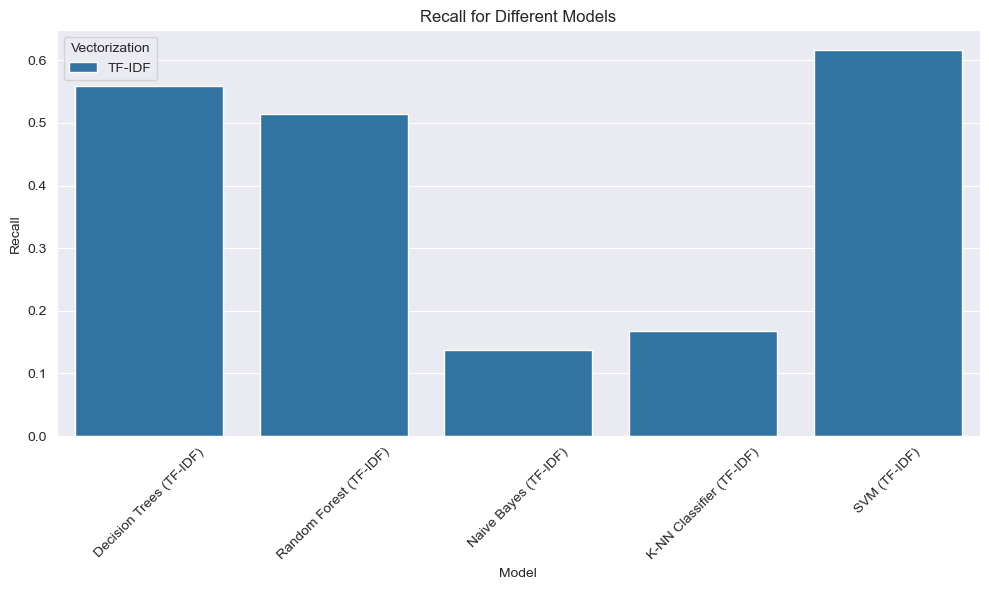

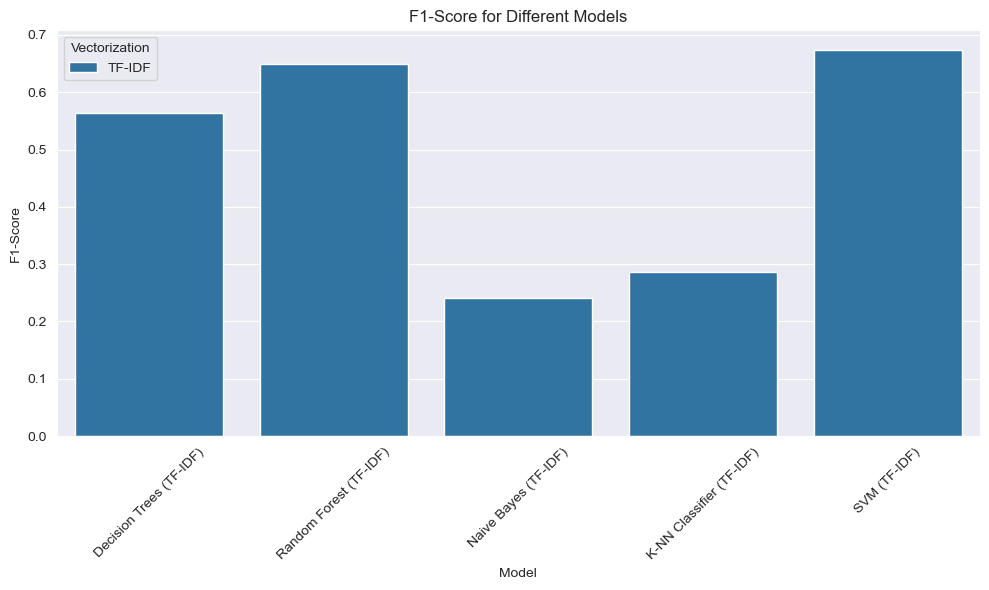

In [16]:
# Generate bar charts for precision, recall, and F1-score for both Bag of Words and TF-IDF models
def generate_bar_chart(metrics_list, metric_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y=metric_name, hue='Vectorization', data=metrics_list)
    plt.xticks(rotation=45)
    plt.title(f'{metric_name} for Different Models')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.savefig(f'{metric_name.lower()}_bar_chart.pdf')
    plt.show()
    plt.close()

metrics_df = pd.DataFrame(metrics_list, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])
metrics_df['Vectorization'] = ['Bag of Words' if 'Bag of Words' in model else 'TF-IDF' for model in metrics_df['Model']]

generate_bar_chart(metrics_df, 'Precision')
generate_bar_chart(metrics_df, 'Recall')
generate_bar_chart(metrics_df, 'F1-Score')

In [17]:

# Function to generate confusion matrix and ROC-AUC curve
def generate_confusion_matrix_and_roc_curve(y_true, y_pred_probs, model_name):
    y_pred = (y_pred_probs >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_confusion_matrix.pdf')
    plt.show()
    plt.close()

    roc_auc = roc_auc_score(y_true, y_pred_probs)
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'{model_name}, ROC-AUC: {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_roc_curve.pdf')
    plt.show()
    plt.close()

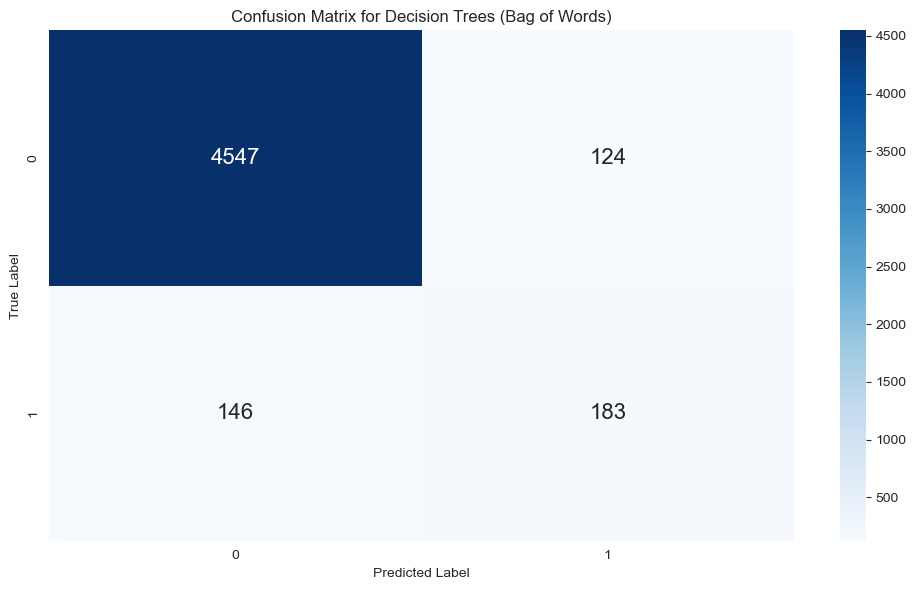

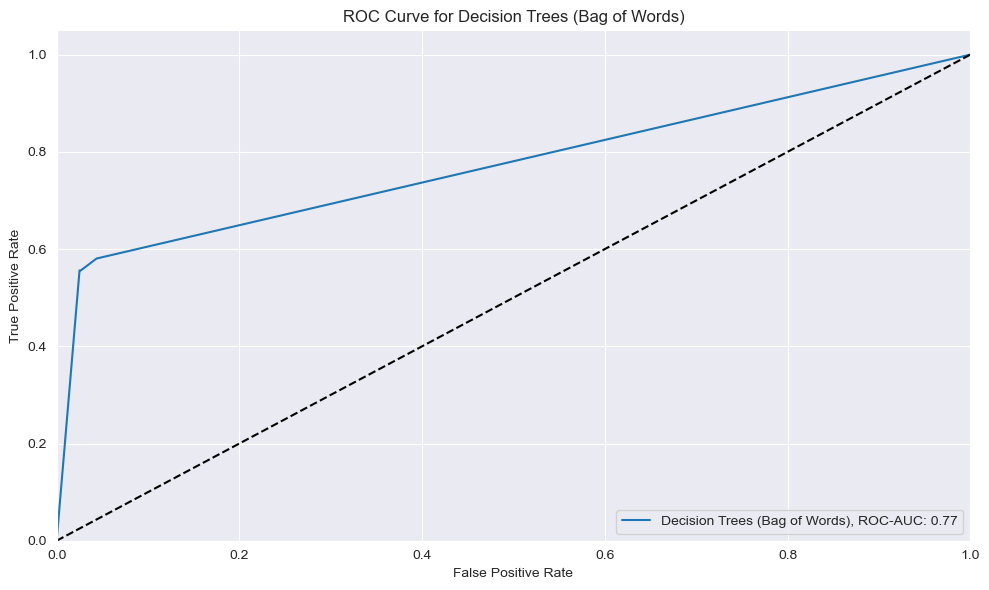

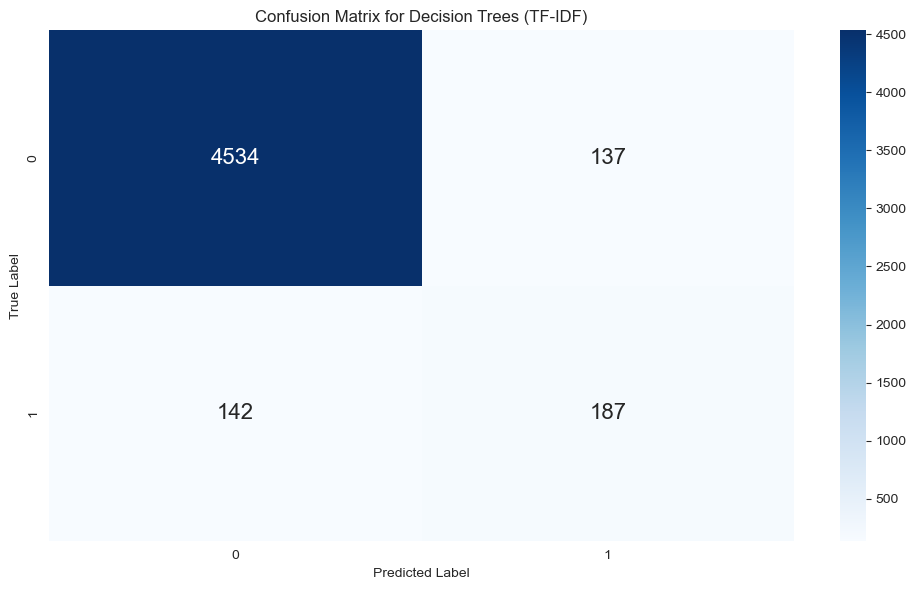

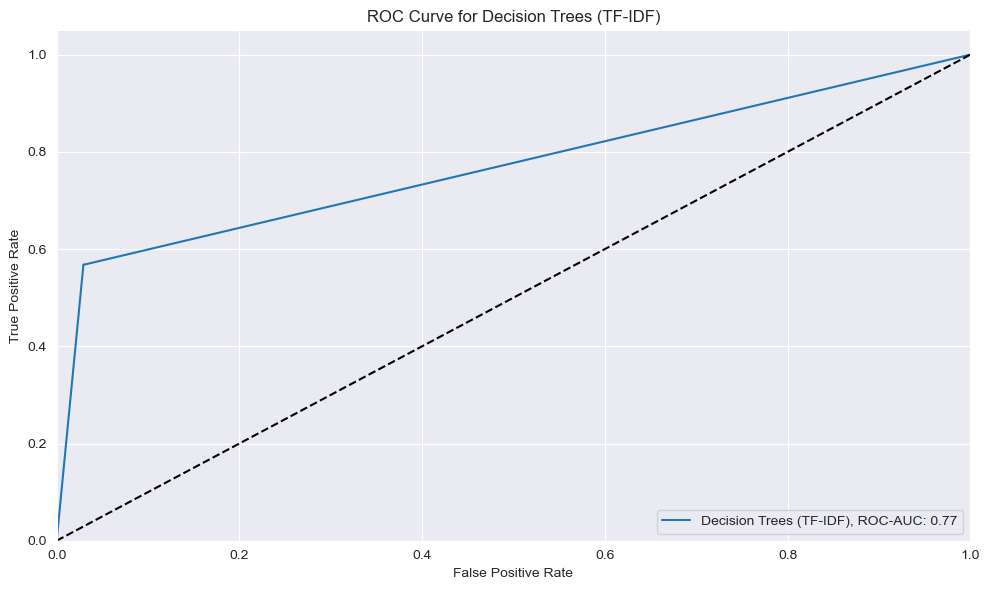

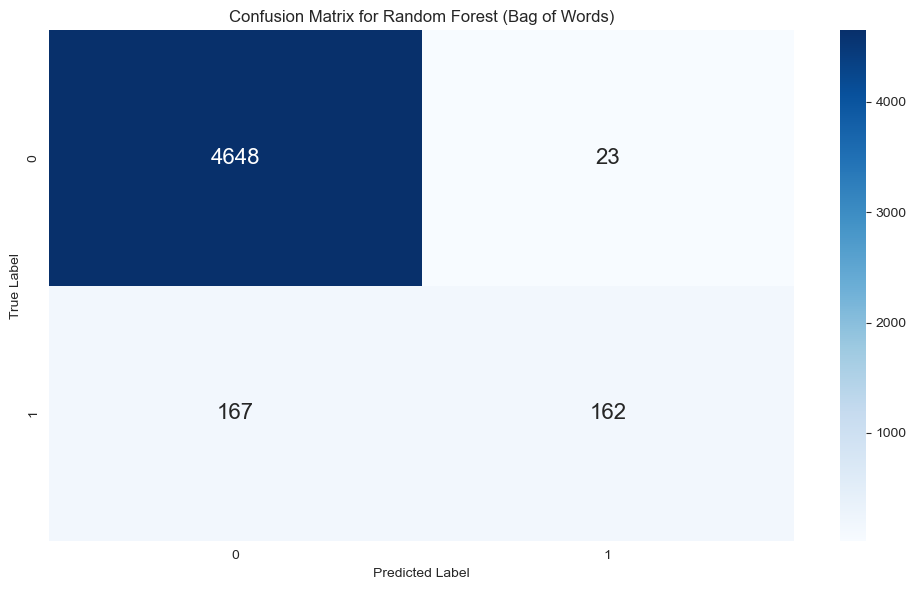

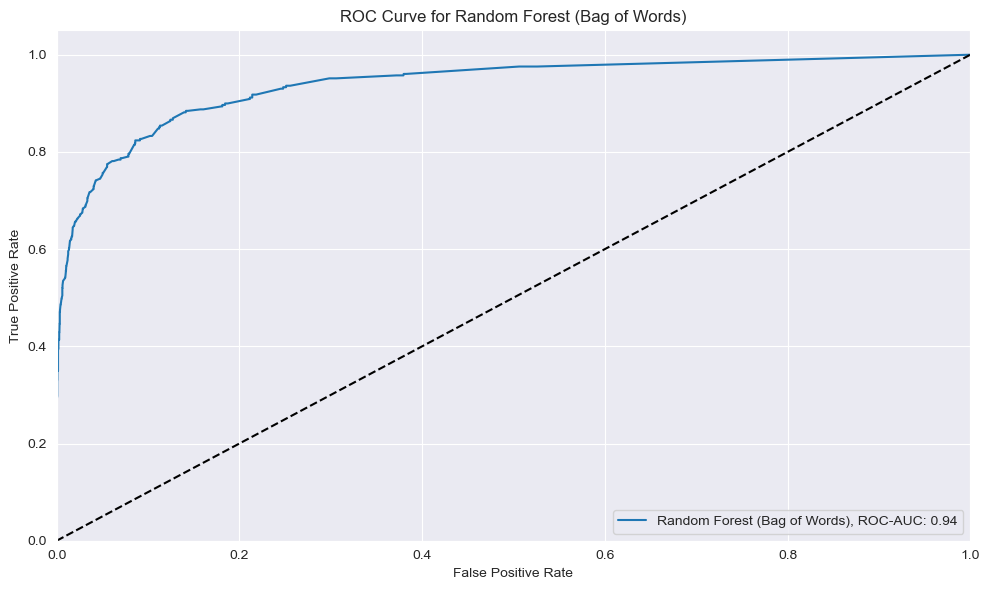

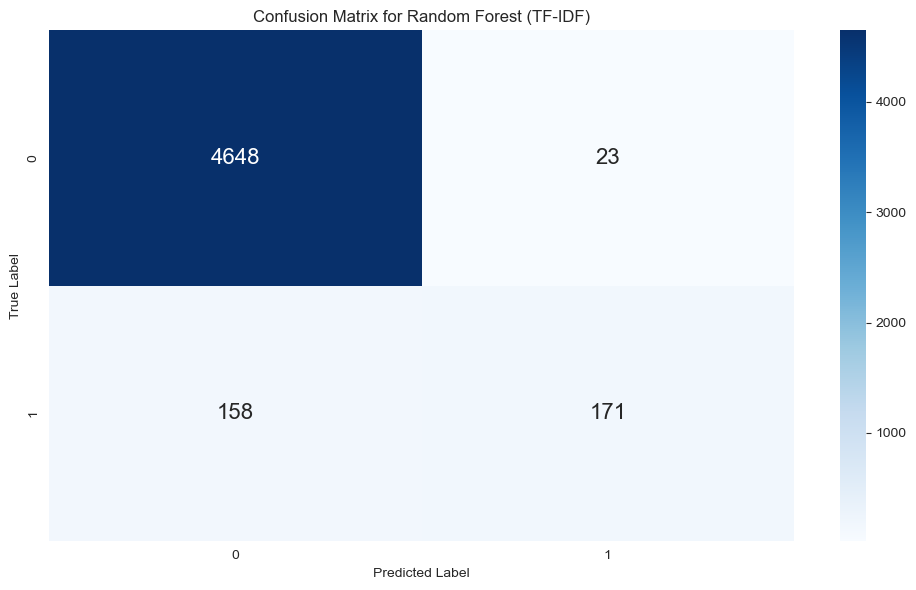

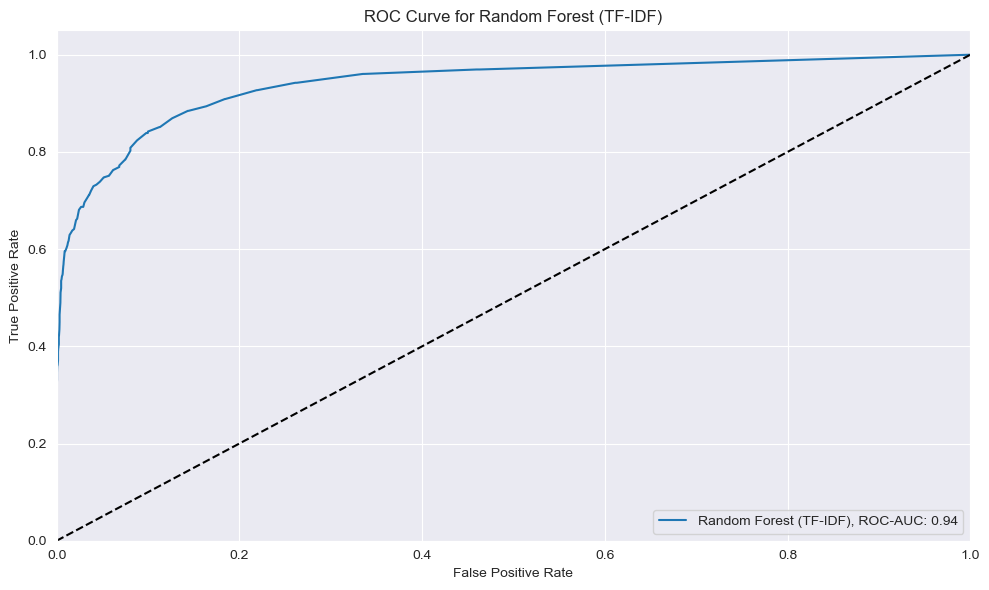

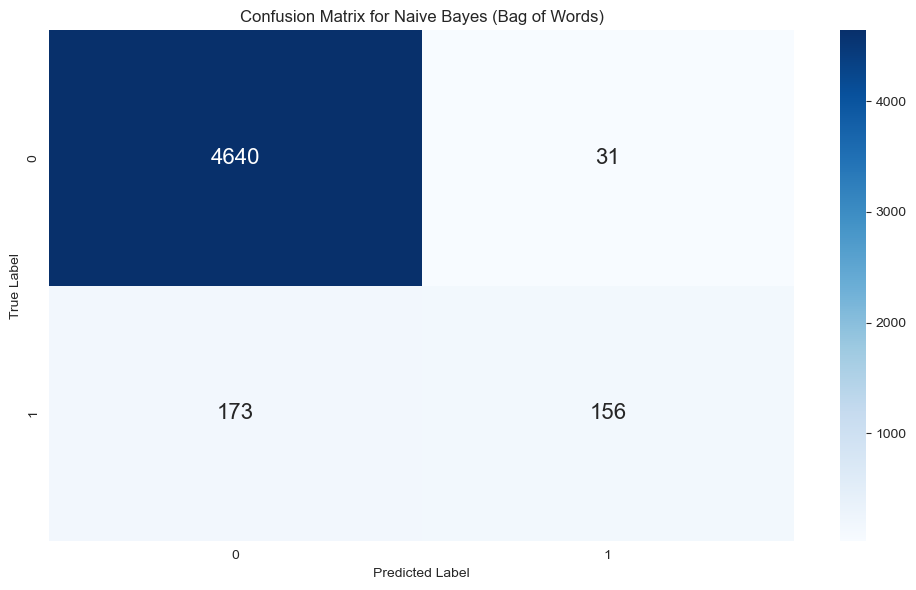

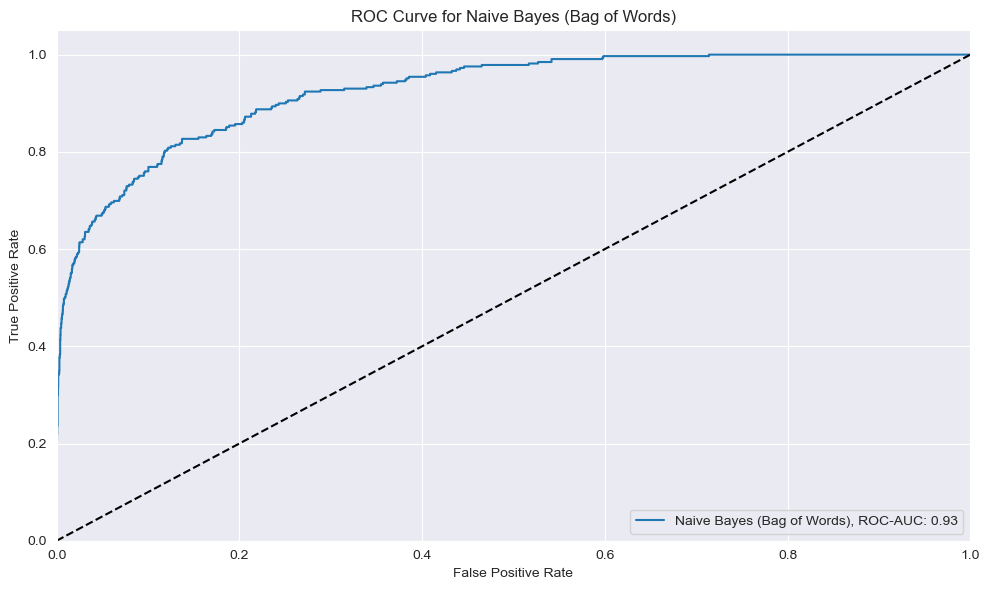

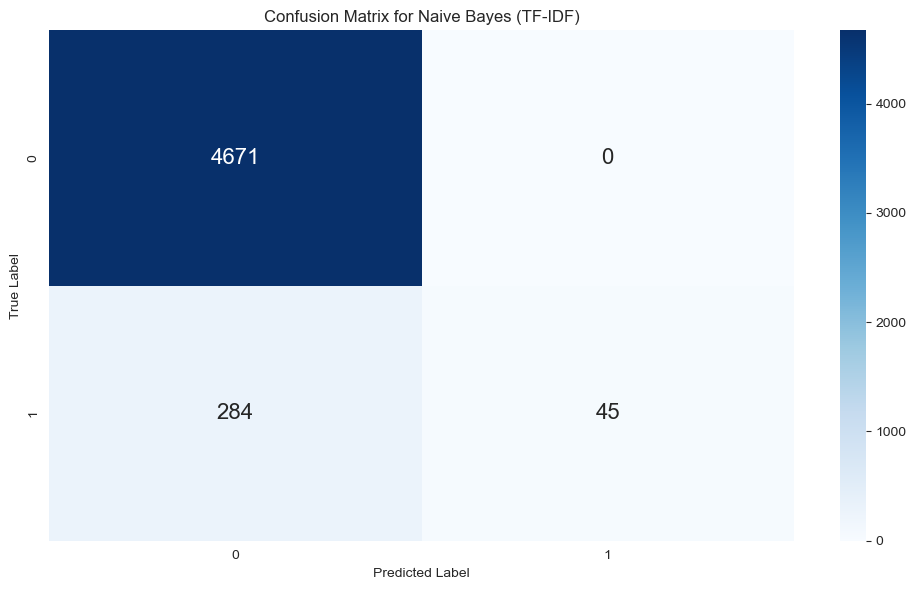

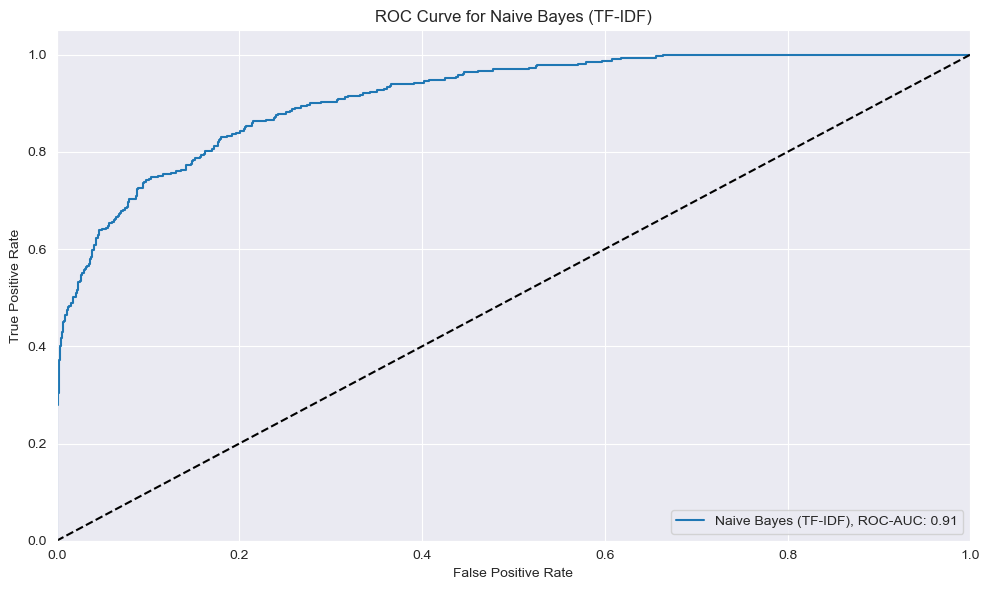

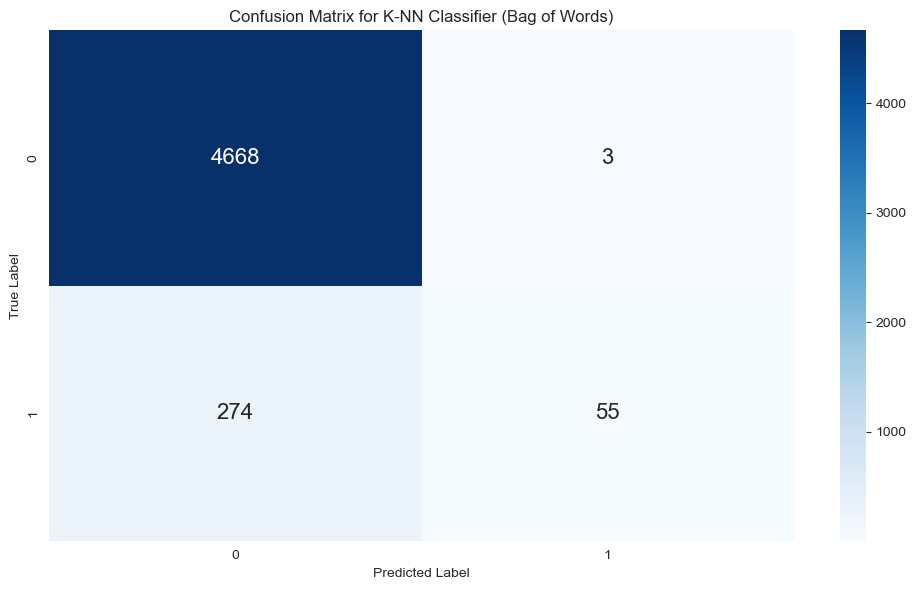

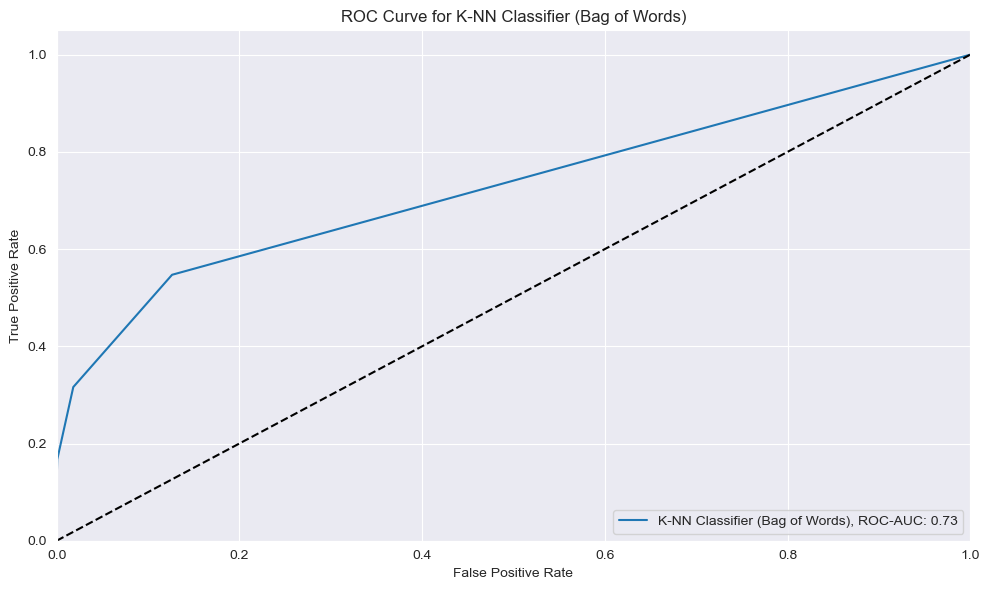

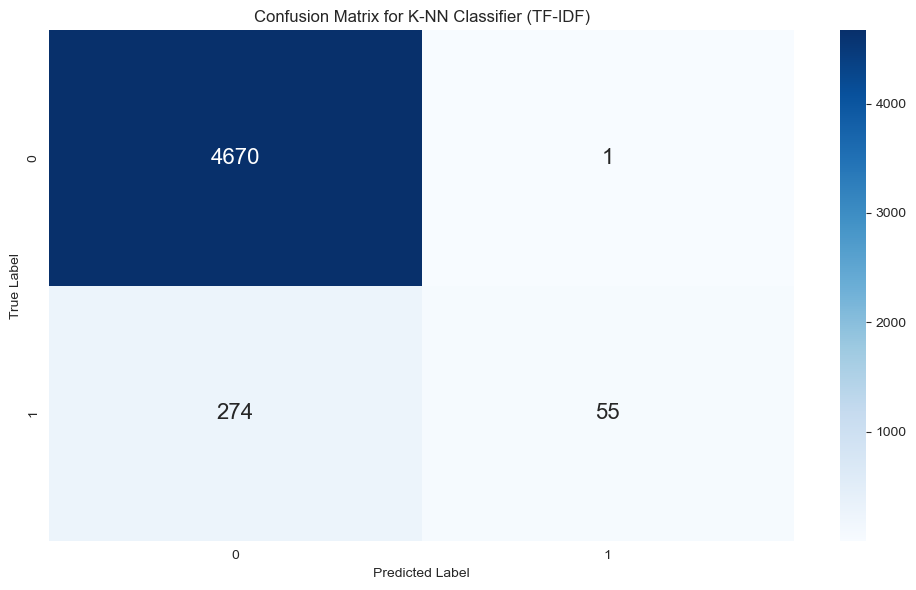

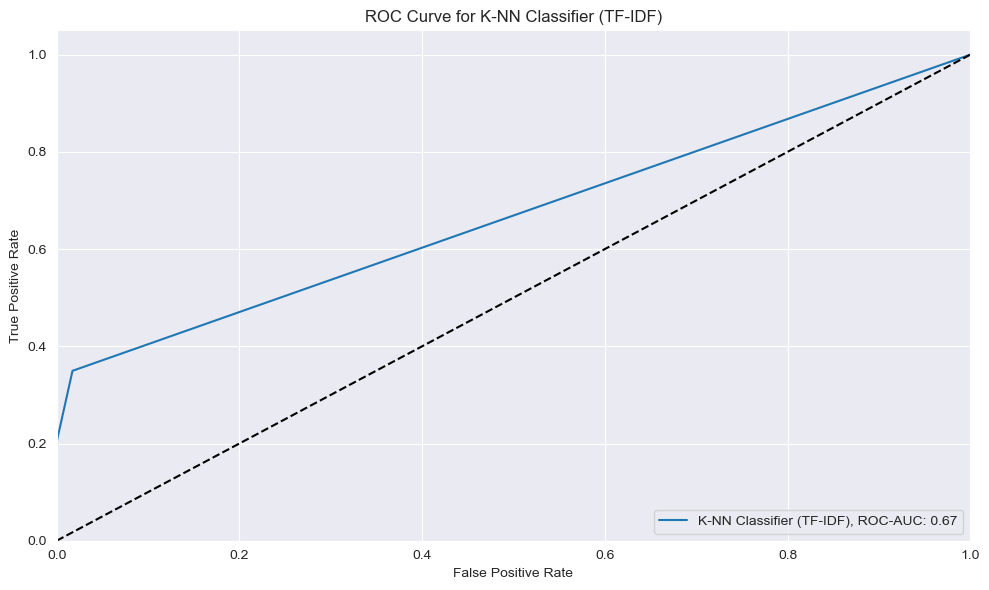

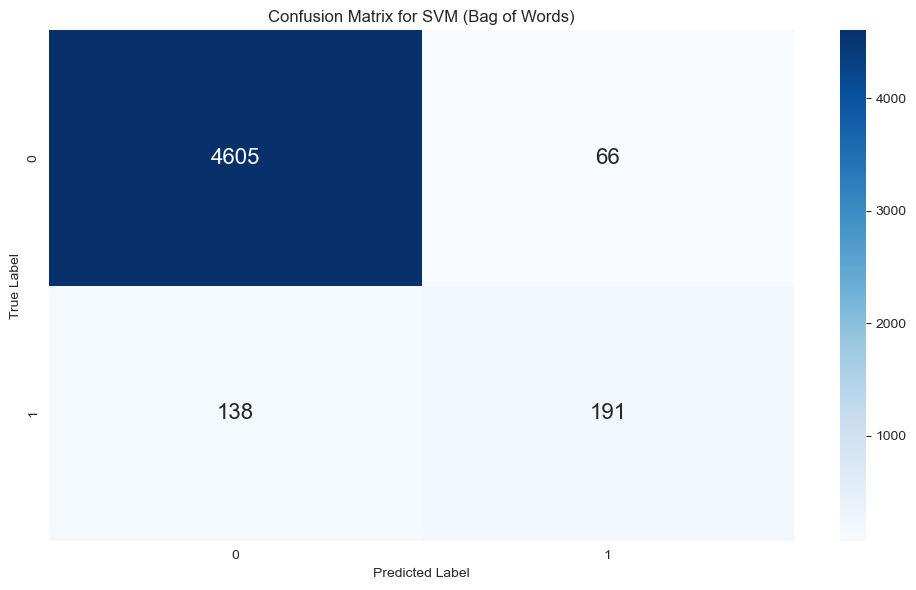

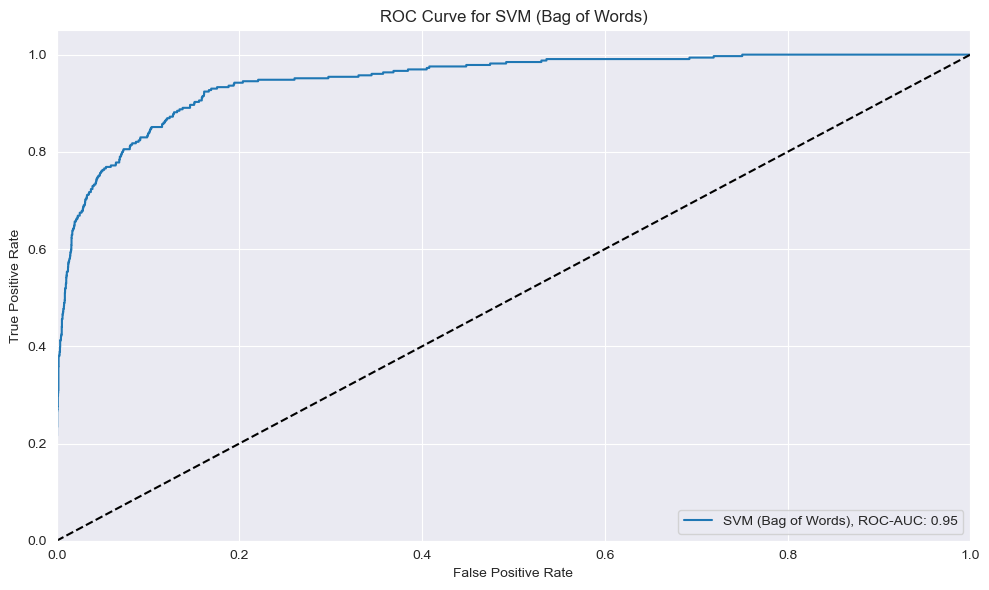

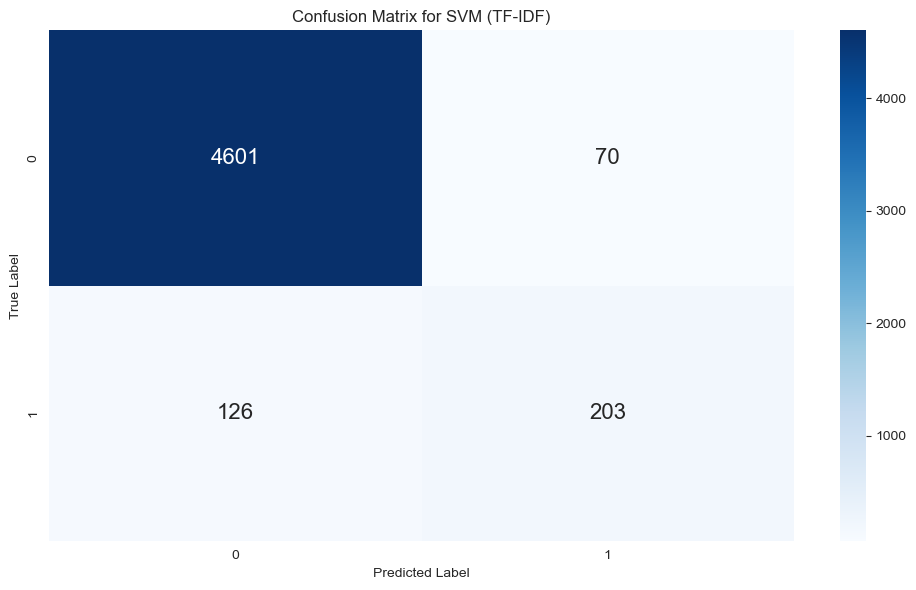

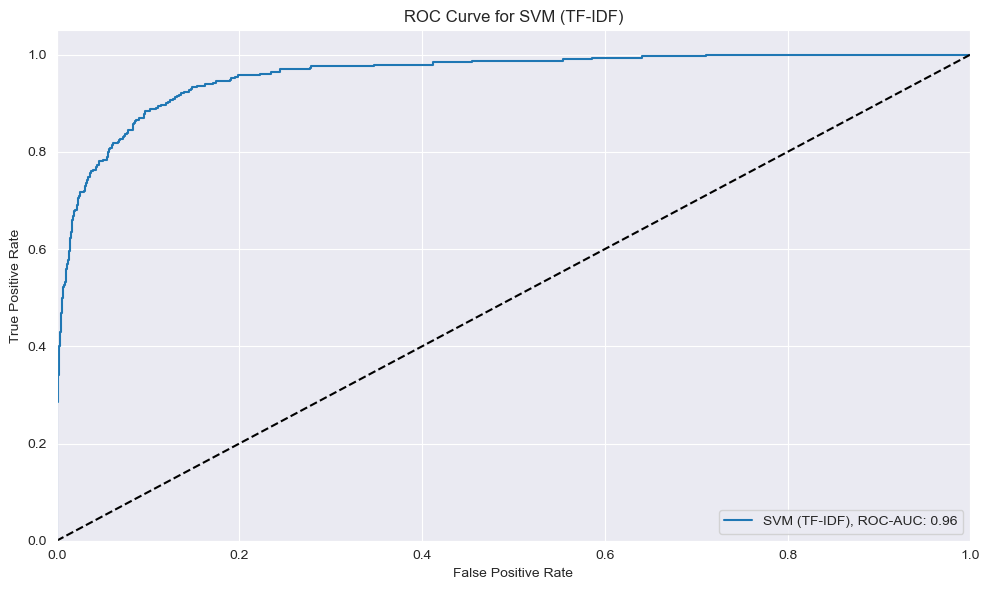

In [18]:

# Generate confusion matrices and ROC-AUC curves for each model for both Bag of Words and TF-IDF
for model_name, model in models.items():
    # Bag of Words
    model.fit(X_train_bow, y_train)
    generate_confusion_matrix_and_roc_curve(y_test, model.predict_proba(X_test_bow)[:, 1], model_name + ' (Bag of Words)')

    # TF-IDF
    model.fit(X_train_tfidf, y_train)
    generate_confusion_matrix_and_roc_curve(y_test, model.predict_proba(X_test_tfidf)[:, 1], model_name + ' (TF-IDF)')

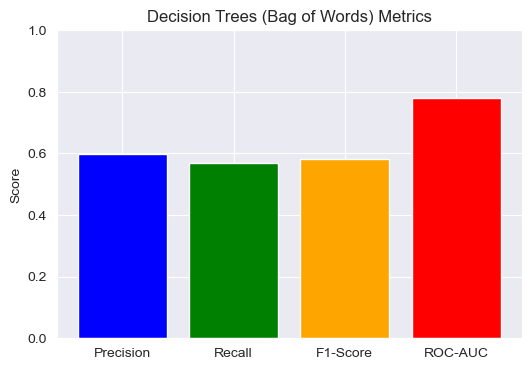

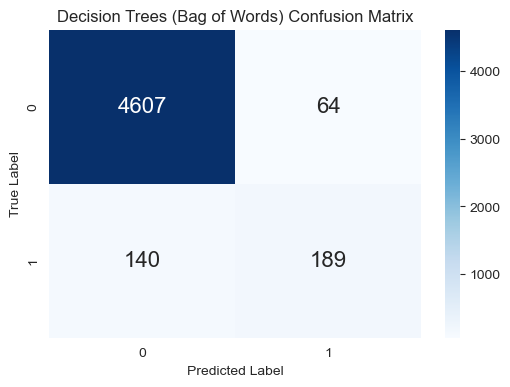

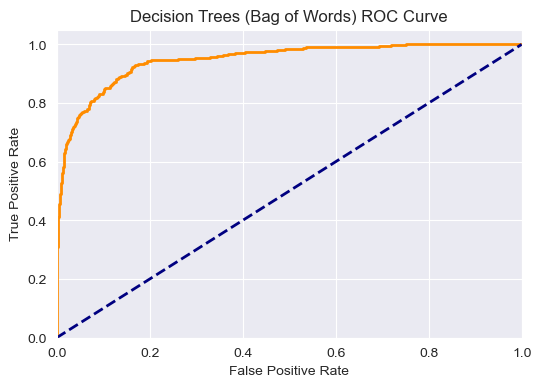

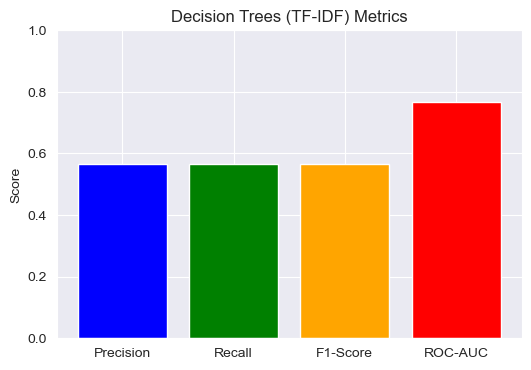

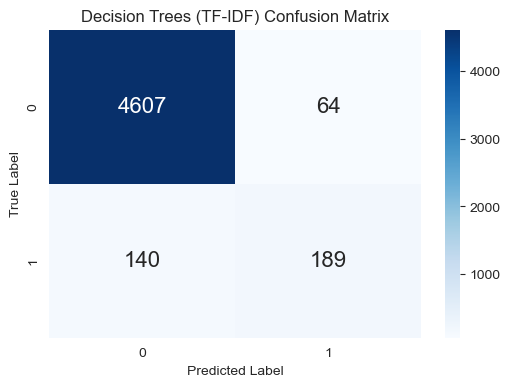

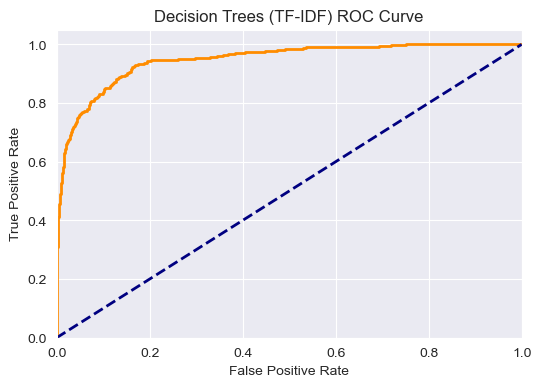

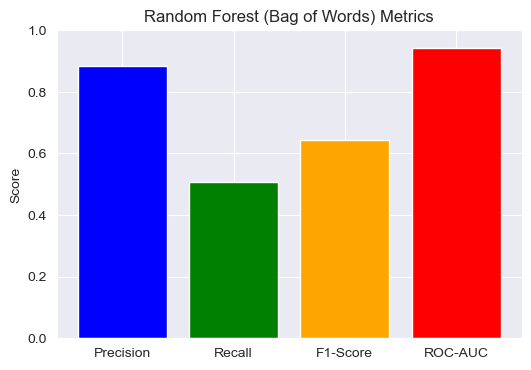

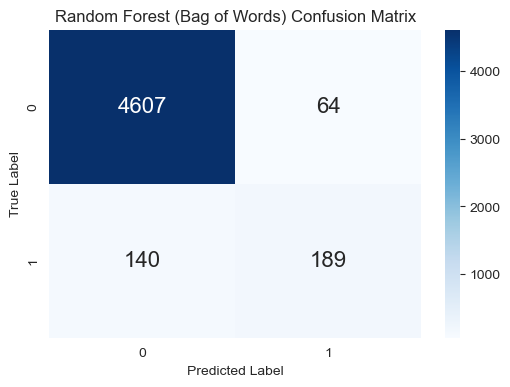

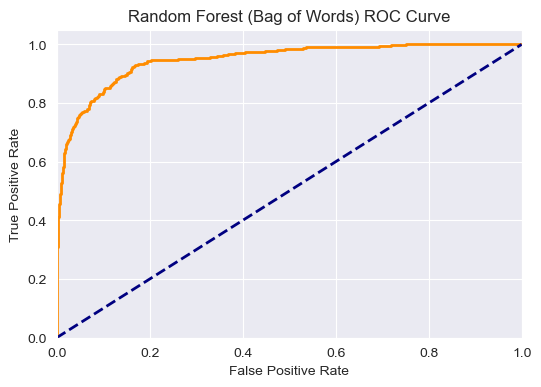

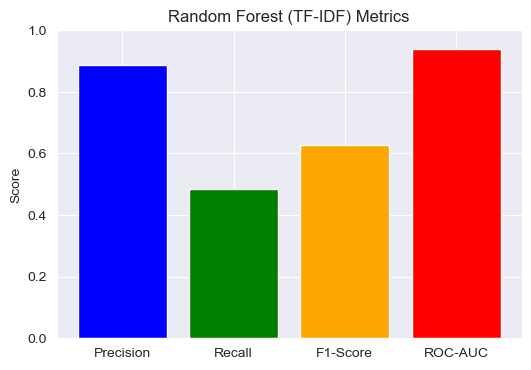

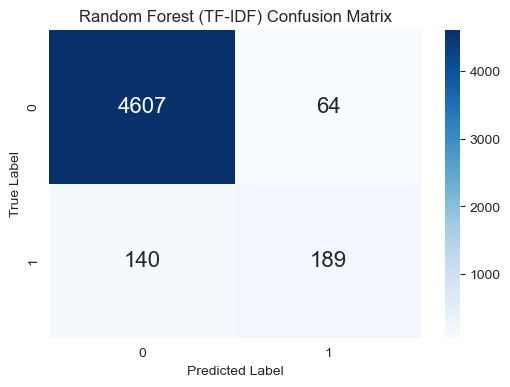

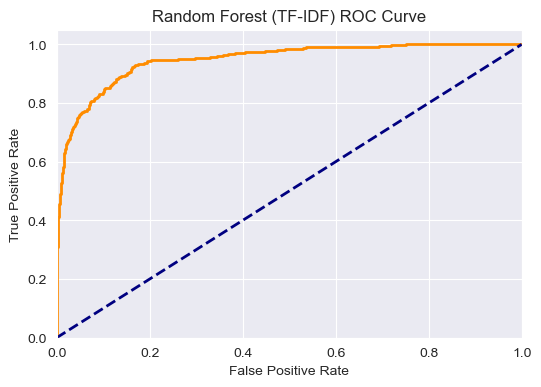

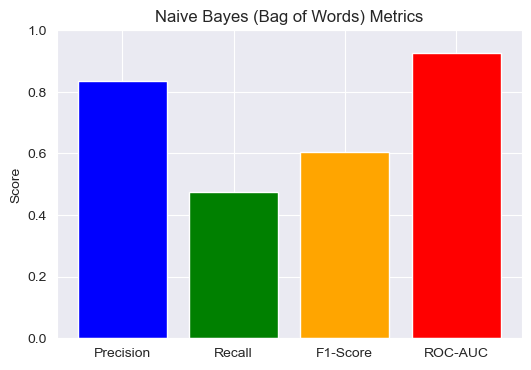

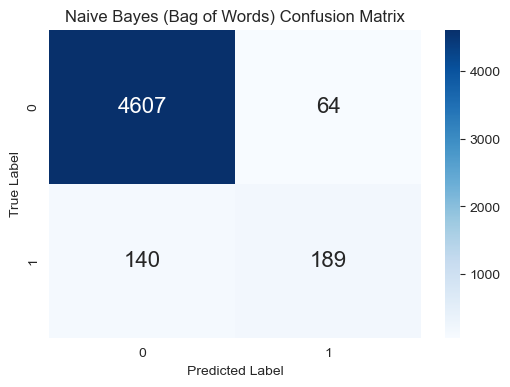

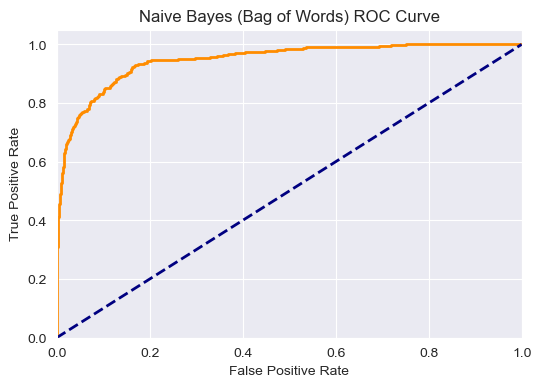

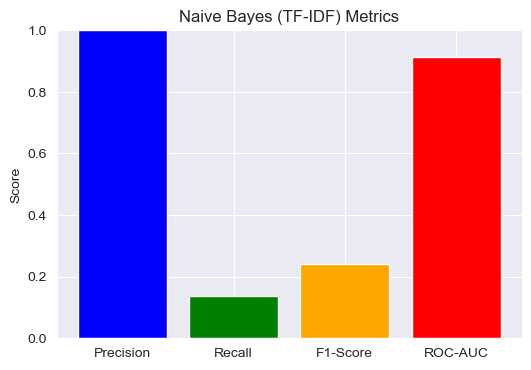

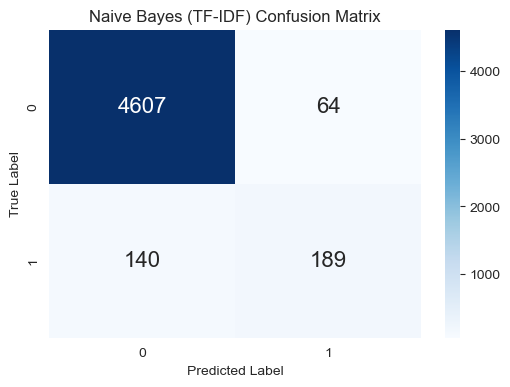

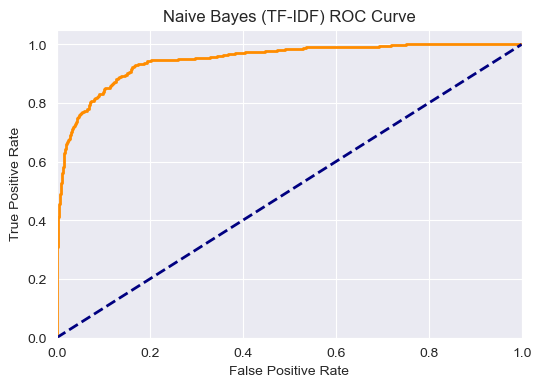

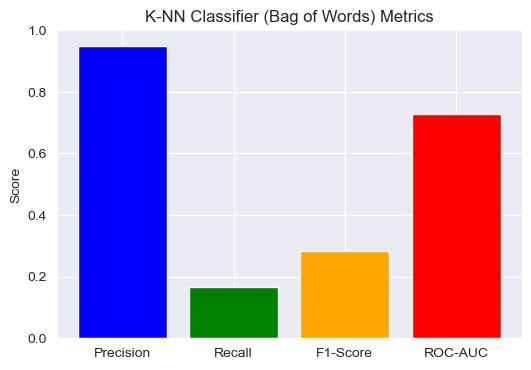

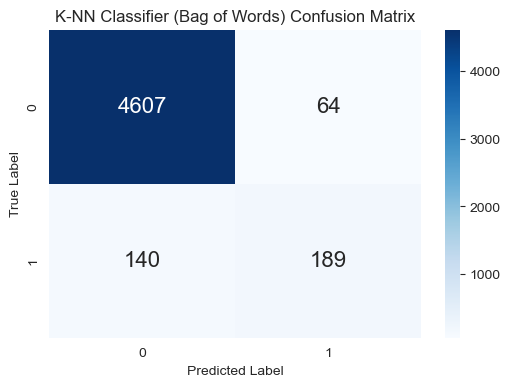

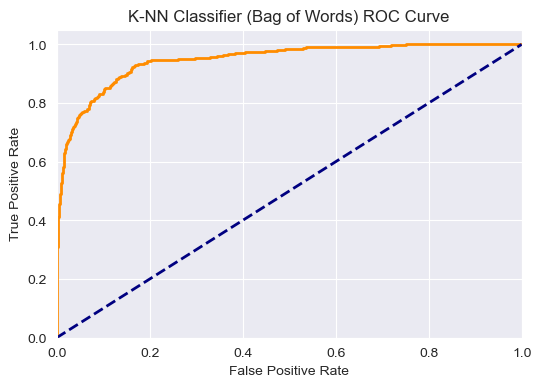

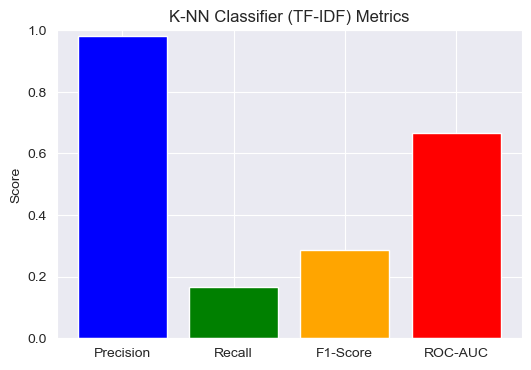

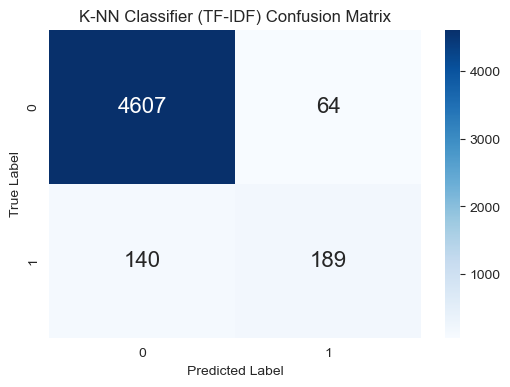

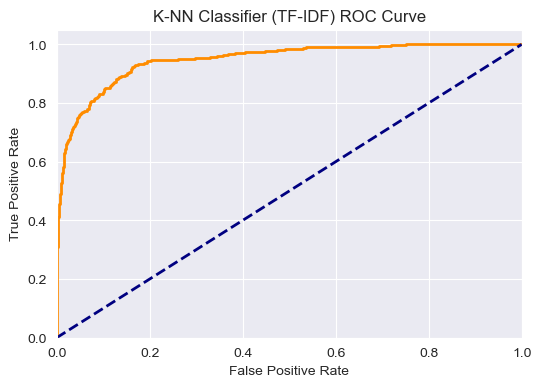

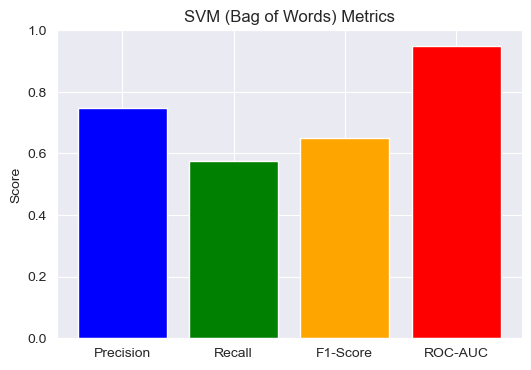

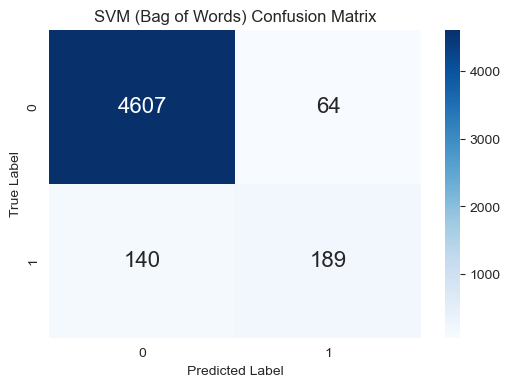

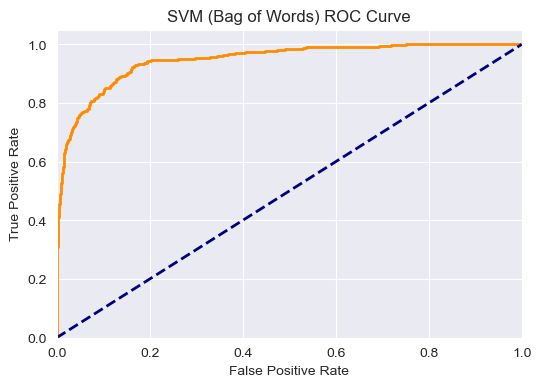

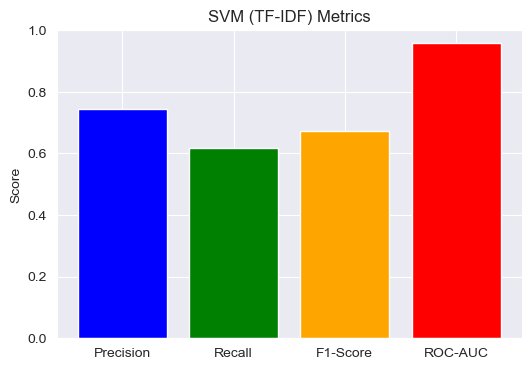

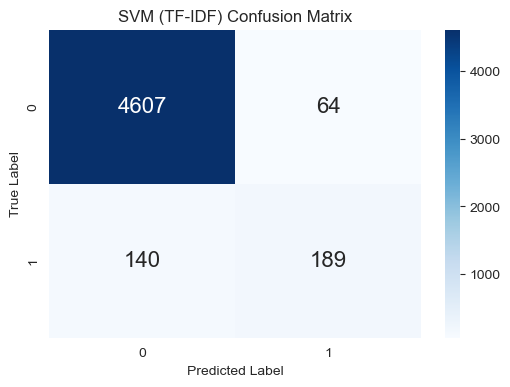

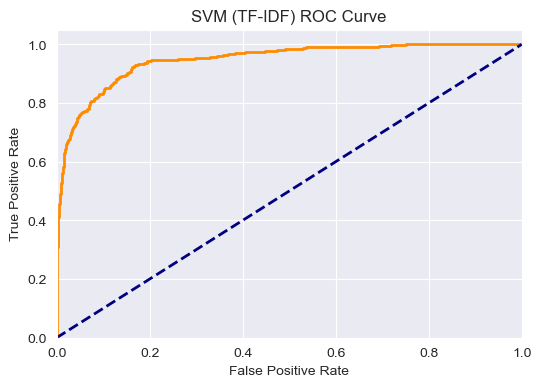

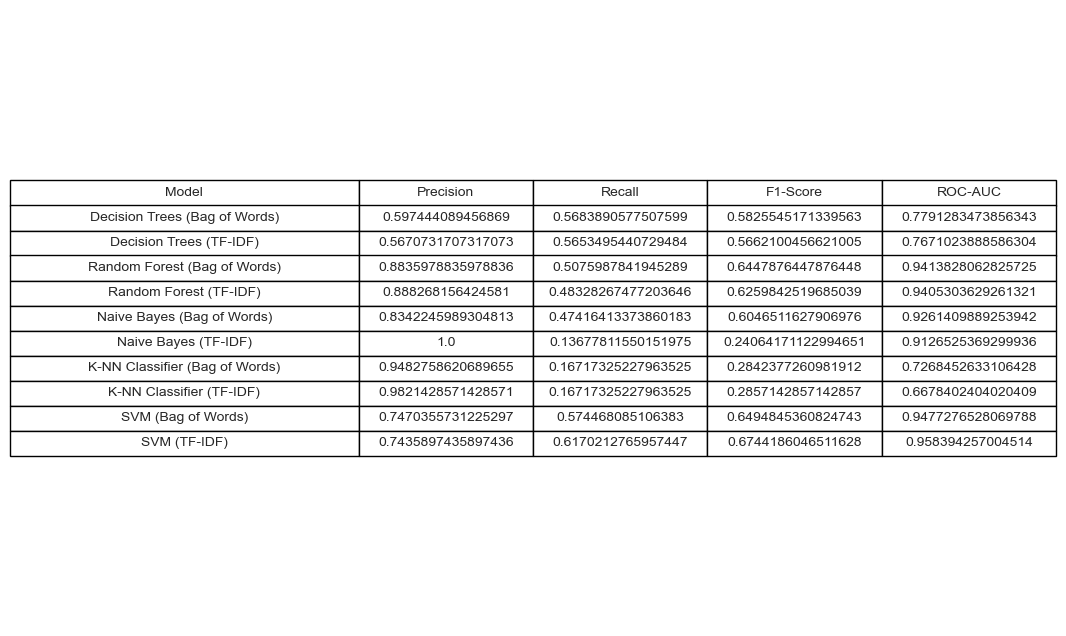

In [38]:

# Combine all generated PDFs into a single PDF
with PdfPages('combined_report.pdf') as pdf:
    # Save the metrics report
    for model_metrics in metrics_list:
        model_name = model_metrics[0]
        precision, recall, f1, roc_auc = model_metrics[1:]

        # Bar chart for Precision, Recall, and F1-Score
        plt.figure(figsize=(6, 4))
        metrics_names = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
        metrics_values = [precision, recall, f1, roc_auc]
        plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
        plt.ylim(0, 1)
        plt.title(f'{model_name} Metrics')
        plt.ylabel('Score')
        pdf.savefig()  # Save each page as a figure in the PDF file
        plt.show()
        plt.close()

        # Confusion Matrix
        cm = confusion_matrix(y_test, (predictions_bow >= 0.5).astype(int))
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        pdf.savefig()  # Save each page as a figure in the PDF file
        plt.show()
        plt.close()

        # ROC-AUC Curve
        fpr, tpr, thresholds = roc_curve(y_test, predictions_bow)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        pdf.savefig()  # Save each page as a figure in the PDF file
        plt.show()
        plt.close()

    # Save the model comparison table
    models = ['Decision Trees (Bag of Words)', 'Decision Trees (TF-IDF)', 'Random Forest (Bag of Words)', 'Random Forest (TF-IDF)',
              'Naive Bayes (Bag of Words)', 'Naive Bayes (TF-IDF)', 'K-NN Classifier (Bag of Words)', 'K-NN Classifier (TF-IDF)',
              'SVM (Bag of Words)', 'SVM (TF-IDF)']

    comparison_table = pd.DataFrame(metrics_list, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])
    comparison_table['Model'] = models

    plt.figure(figsize=(10, 8))
    plt.axis('off')
    table = plt.table(cellText=comparison_table.values,
                      colLabels=comparison_table.columns,
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.3, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)
    pdf.savefig()  # Save the table as a figure in the PDF file
    plt.show()
    plt.close()